# Pillow的基本操作

In [13]:
from PIL import Image,ImageFilter

img = Image.open('dog.jpg')
#模糊滤镜
img1 = img.filter(ImageFilter.BLUR)
img1.save('blur.jpg', 'jpeg')

width = img.size[0]
height = img.size[1]
#缩放
img.thumbnail((width//2, height//2))
img.save('thumbnail.jpg', 'jpeg')

# OpenCV的基本操作

(206, 208, 3)


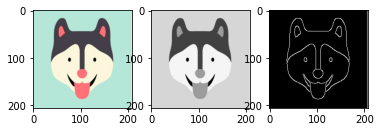

True

In [24]:
import cv2
import matplotlib.pyplot as plt

plt.figure()
img = cv2.imread('dog.jpg')
print(img.shape)  #(height, width, channel)
#转为RGB进行显示
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(1,3,1)
plt.imshow(img1)

#转为灰度图片
img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
cv2.imwrite('gray.jpeg', img2)

#canny边缘检测
edges = cv2.Canny(img, 30, 70)
plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('edge.jpeg', edges)

# 数据扩增

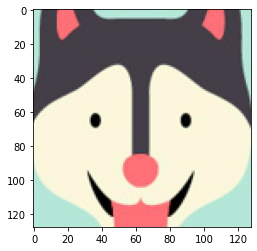

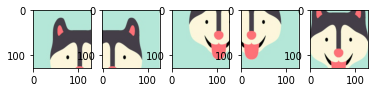

In [42]:
from PIL import Image
import torchvision.transforms
import matplotlib.pyplot as plt

img = Image.open('dog.jpg')

#对图片中心进行裁剪
crop_obj = torchvision.transforms.CenterCrop((128,128))
plt.figure()
img1 = crop_obj(img)
#plt.subplot(1,6,1)
plt.imshow(img1)

#对图片四个角和中心进行裁剪得到五分图像
fivecrop_obj = torchvision.transforms.FiveCrop((128,128))
crop_imgs = fivecrop_obj(img)
plt.figure()
for index, crop_img in enumerate(crop_imgs):
    plt.subplot(1,5,index+1)
    plt.imshow(crop_img)


# 数据读取

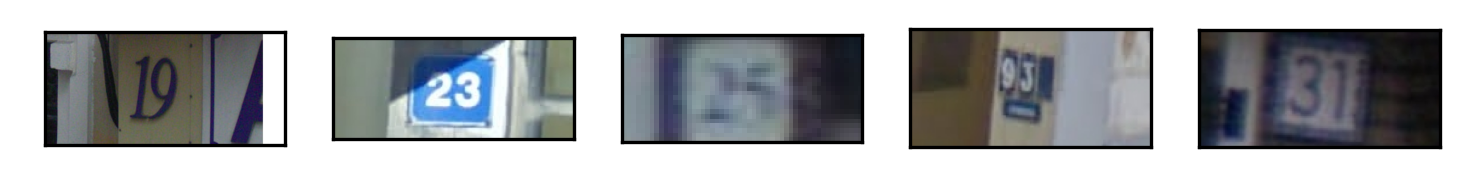

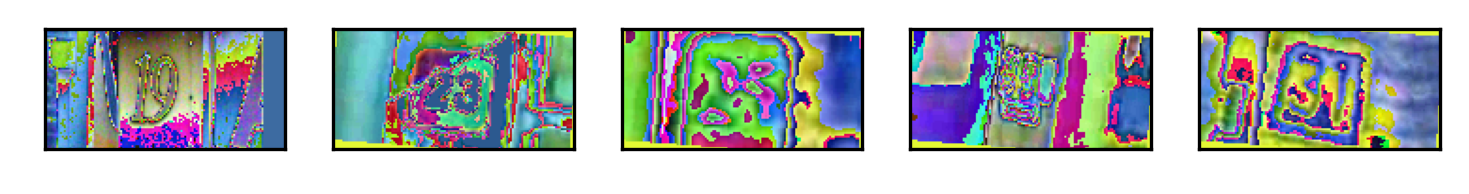

In [17]:
import os, sys, glob, shutil, json
import cv2
from PIL import Image
import numpy as np
import torch
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')

        if self.transform is not None:
            img1 = self.transform(img)
            img = img1
        # 原始SVHN中类别10为数字0
        lbl = np.array(self.img_label[index], dtype=np.int)
        a = (5 - len(lbl)) * [10]
        lbl = list(lbl) + (5 - len(lbl)) * [10]
        return img, torch.from_numpy(np.array(lbl[:5]))

    def __len__(self):
        return len(self.img_path)

train_path = glob.glob('./input/train/*.png')
train_path.sort()
train_json = json.load(open('./input/train.json'))
train_label = [train_json[x]['label'] for x in train_json]

#显示变换前的图片
plt.figure(dpi=300)
for index, img in enumerate(train_path[:5]):
    plt.subplot(1,5,index+1)
    plt.imshow(Image.open(img))
    plt.xticks([]);
    plt.yticks([])

train_loader = torch.utils.data.DataLoader(
    SVHNDataset(train_path, train_label,
        transforms.Compose([
        # 缩放到固定尺⼨
        transforms.Resize((64, 128)),
        # 随机颜⾊变换
        transforms.ColorJitter(0.3, 0.3, 0.2),
        # 加⼊随机旋转
        transforms.RandomRotation(5),
        # 将图⽚转换为pytorch 的tesntor
        transforms.ToTensor(),
        # 对图像像素进⾏归⼀化
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])),
    batch_size=5, # 每批样本个数
    shuffle=False, # 是否打乱顺序
    num_workers=10, # 读取的线程个数
)

for data in train_loader:
    imgs = data[0]
    labels = data[1]
    plt.figure(dpi=300)
    for index, tensor_img in enumerate(imgs):
        plt.subplot(1, 5, index + 1)
        pil_image = transforms.ToPILImage()(tensor_img).convert('RGB')
        plt.imshow(pil_image)
        plt.xticks([])
        plt.yticks([])
    break